# MCBDD Offline Activities Module II

In [106]:
from chembl_webresource_client.new_client import new_client
import requests
import json
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

## Step 1

Retrieve all approved drugs from the ChEMBL database, sort them by approval year and name (a Python example is at https://github.com/chembl/chembl_webresource_client; documentations of the ChEMBL API can be found at https://www.ebi.ac.uk/chembl/api/data/docs). How many drugs did you get?

In [4]:
# connect to API
drugs = new_client.drug

print('Number of approved drugs: {}'.format(len(drugs)))

Number of approved drugs: 13721


In [178]:
def get_INN(drug: list):
    """returns INN name, use ; as concatenator if more than one value is available"""
    inn = [x['molecule_synonym'] for x in drug['molecule_synonyms'] if x['syn_type'] == 'INN']
    res = ';'.join(inn)
    return(res)

In [179]:
ids = [x['molecule_chembl_id'] for x in drugs]
names = [get_INN(x) for x in drugs]
years = [x['first_approval'] for x in drugs]

In [49]:
# make dataframe with IDs, INN names, year of first approval
drugList = pd.DataFrame({'ID':ids, 'Name':names, 'FirstApproval':years})
drugList.sort_values(by=['Name', 'FirstApproval'], axis=0, inplace=True)

drugList

,ID,Name,FirstApproval
263,CHEMBL90,,1939.0
1056,CHEMBL821,,1939.0
2873,CHEMBL190,,1940.0
4535,CHEMBL1201649,,1942.0
4250,CHEMBL1201235,,1943.0
...,...,...,...
2444,CHEMBL167779,Zuclomifene,NaN
1304,CHEMBL53904,Zuclopenthixol,NaN
12335,CHEMBL4105630,Zuranolone,NaN
12780,CHEMBL4297637,Zuretinol acetate,NaN


## Step 2
For each approved drug *since 2011* that you identified in step (1), retrieve a list of UniProt accession numbers, namely protein targets associated with the drug. On average, how many protein targets are associated with each compound? Report the median value here.

In [50]:
year = 2011
# approvalsYear = drugs.filter(first_approval__gte=year) # alternative to filter the API query directly
approvalsYear = drugList.query('FirstApproval >= {}'.format(year)).sort_values(by='FirstApproval', axis=0)

approvalsYear

,ID,Name,FirstApproval
3164,CHEMBL271227,,2011.0
5208,CHEMBL1628502,Gabapentin enacarbil,2011.0
10676,CHEMBL2218860,Gadobutrol,2011.0
5465,CHEMBL1742994,Brentuximab vedotin,2011.0
2573,CHEMBL439849,Vilazodone,2011.0
...,...,...,...
11824,CHEMBL3833307,Satralizumab,2020.0
13282,CHEMBL4298187,Ferric derisomaltose,2020.0
10667,CHEMBL2205807,Abametapir,2020.0
7071,CHEMBL2105248,,2020.0


In [52]:
# make empty dictionary to store targets for each compound
compounds2targets = dict() 

# set ChEMBL ID as key and assign empty set to this key
for compound in approvalsYear.ID:
    compounds2targets[compound] = set() 
    
# process activities (queries) in chunks
chunk_size = 50

keys = list(compounds2targets.keys())

for i in range(0, len(keys), chunk_size):
    # we jump from compounds to targets through activities:
    activities = new_client.activity.filter(molecule_chembl_id__in=keys[i:i + chunk_size]).only(['molecule_chembl_id', 'target_chembl_id'])
    # extracting target ChEMBL IDs from activities:
    for act in activities:  
        compounds2targets[act['molecule_chembl_id']].add(act['target_chembl_id'])


# convert ChEMBL ID of targets to UniProt accession number

for key, val in compounds2targets.items():
    # targets are processed in chunks since number of targets per compound is unkown
    lval = list(val)
    uniprots = set()
    for i in range(0, len(val), chunk_size):
        targets = new_client.target.filter(target_chembl_id__in=lval[i:i + chunk_size]).only(['target_components'])
        uniprots |= {comp['accession'] for t in targets for comp in t['target_components']}

    compounds2targets[key] = uniprots

In [56]:
compounds2targets_df = pd.DataFrame([(i, uniprot) for i, j in compounds2targets.items() for uniprot in j], columns=['ID','UniProt'])

compounds2targets_df

,ID,UniProt
0,CHEMBL271227,P10275
1,CHEMBL271227,P05093
2,CHEMBL271227,P0DTD1
3,CHEMBL1628502,P0DTD1
4,CHEMBL2218860,P0DTD1
...,...,...
15716,CHEMBL243712,P19328
15717,CHEMBL2205807,P32246
15718,CHEMBL2205807,P51685
15719,CHEMBL2205807,P0DTD1


In [57]:
# save to file since obtaining the data is very time-consuming
# so it can be loaded directly from file instead of api if kernel is restarted

compounds2targets_df.to_csv('20210701-ChEMBL-drugs-since-2011-UniProt.tsv.gz', sep='\t')

In [73]:
# median number of targets associated with each compound
targetsNo = dict()
for compound in compounds2targets_df.ID:
    if compound not in targetsNo.keys():
        targetsNo[compound] = len(compounds2targets[compound])

medianTargets = np.median(list(targetsNo.values()))

print('Median number of protein targets associated with each compound {}'.format(medianTargets))

Median number of protein targets associated with each compound 7.0


## Step 3
for each protein with a UniProt accession number that you identified in step (2), retrieve UniProt keywords associated with it. You can use the UniProt API, documented at https://www.ebi.ac.uk/proteins/api/doc/#!/proteins/search. Python (https://pypi.org/project/uniprot_tools/) and R (https://github.com/lgatto/UniProt.REST) clients are also available. Which keyword(s) is associated with most drugs approved since 2011?

In [164]:
def get_keywords(protein: list):
    """process list removing/avoiding KeyErrors from None types"""
    try:
        res = [list(k.values())[0] for k in protein['keywords']]
        if res == None:
            res = []
    except KeyError:
        res = []
    return(res)

In [165]:
# use set to remove duplicates
uniprots = list(set(compounds2targets_df.UniProt))

# base URL
requestURL = 'https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=100&accession='

# query will be processed in chunks of 100
# there seems to be a problem with processing queries larger than ~110

# build query by joining list of UniProt numbers to string 
chunk_size = 100
keywords = []

for i in range(0, len(uniprots), chunk_size):
    query = ','.join(uniprots[i:i + chunk_size])
    # connect to API
    url = requestURL + query
    r = requests.get(url, headers={'Accept': 'application/json'})
    for jlist in r.json():
        keywords.extend(get_keywords(jlist))


In [176]:
# getting keyword frequency with collections.Counter
keyword_counter = Counter(keywords)
print(keyword_counter)

Counter({'Reference proteome': 1344, 'Phosphoprotein': 882, '3D-structure': 872, 'Membrane': 778, 'Alternative splicing': 742, 'Nucleotide-binding': 599, 'Transferase': 555, 'ATP-binding': 548, 'Cytoplasm': 536, 'Cell membrane': 532, 'Transmembrane': 528, 'Transmembrane helix': 527, 'Glycoprotein': 525, 'Kinase': 463, 'Metal-binding': 425, 'Disulfide bond': 409, 'Nucleus': 408, 'Disease variant': 350, 'Serine/threonine-protein kinase': 337, 'Receptor': 328, 'Signal': 311, 'Direct protein sequencing': 299, 'Ubl conjugation': 299, 'Acetylation': 295, 'Repeat': 251, 'Hydrolase': 228, 'Transport': 206, 'Magnesium': 191, 'Lipoprotein': 169, 'Zinc': 162, 'Transducer': 159, 'G-protein coupled receptor': 157, 'Cell junction': 155, 'Ion transport': 151, 'Isopeptide bond': 145, 'Transcription': 142, 'Transcription regulation': 142, 'Cell projection': 127, 'Synapse': 125, 'Palmitate': 125, 'Endoplasmic reticulum': 123, 'Tyrosine-protein kinase': 122, 'Cytoskeleton': 120, 'Ion channel': 109, 'Cell

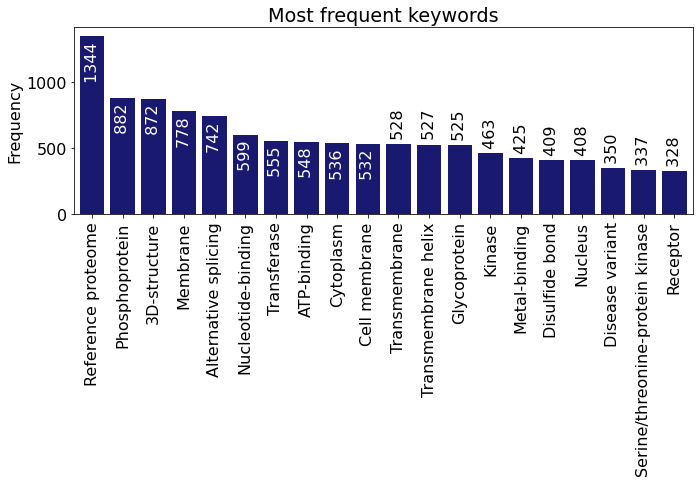

In [193]:
# plotting most frequent keywords
most_common_keywords = keyword_counter.most_common(20)
y = [count for keyword, count in most_common_keywords]
x = [keyword for keyword, count in most_common_keywords]

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams.update({'font.size': 16})

plt.bar(x, y, color='midnightblue')
plt.title("Most frequent keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(most_common_keywords):
    plt.text(i, count, f' {count} ', rotation=90, size=16,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) 
plt.tight_layout() 
plt.show()